<a href="https://colab.research.google.com/github/OkoksNeDam/HSE-ComputerVisionTechnologies/blob/main/models/LinearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset with Pytorch



## Load the data

In [98]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn.model_selection
import sklearn.metrics
from tqdm import tqdm


TRAIN_SIZE = 40_000
VAL_SIZE = 10_000
TEST_SIZE = 10_000

GENERATOR = torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [99]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        nn.Flatten(0) # [3, 32, 32] -> [3072]
    ]
)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Split dataset & define dataloaders

In [100]:
train, val, _ = torch.utils.data.random_split(train_set, [TRAIN_SIZE, VAL_SIZE, len(train_set) - (TRAIN_SIZE + VAL_SIZE)], generator=GENERATOR)
test, _ = torch.utils.data.random_split(test_set, [TEST_SIZE, len(test_set) - TEST_SIZE], generator=GENERATOR)

In [101]:
assert len(train) == TRAIN_SIZE
assert len(test) == TEST_SIZE
assert len(val) == VAL_SIZE

In [102]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader = torch.utils.data.DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

test_dataloader = torch.utils.data.DataLoader(
    test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

val_dataloader = torch.utils.data.DataLoader(
    val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

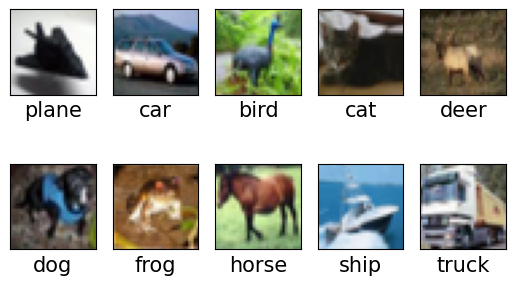

In [103]:
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
fig, axes = plt.subplots(2, 5)
plt.subplots_adjust(top = 0.7)
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i].reshape((32,32,3)))
    i += 1

# Analytic gradient computation

In this work we will use Hinge loss function:
$$
Q_i = \sum\limits_{j!=y_i}^d
\begin{cases}
    0, s_{y_i} >= s_j + 1 \\
    s_j - s_{y_i} + 1, otherwise
\end{cases}\
= \sum\limits_{j!=y_i}^d {max(0, s_j - s_{y_i} + 1)}
$$
where $y_i$ is index for true class on image $i$, $s_j$ is prediction for class $j$.\
Loss for batch size $B$: $L = \frac{1}{B}\sum\limits_{i=1}^B{L_i}$\
Let us write the response of each class through the scalar product:
$$
Q_i =
\sum\limits_{j!=y_i}^d{max(0, s_j - s_{y_i} + 1)}=
\sum\limits_{j!=y_i}^d{max(0, w_{j}^T*x_i - w_{y_i}^T*x_i + Δ)}
$$\
where $w_j$ are weights corresponding to class $j$, $d$ is number of classes.\
Let's find gradient of Hinge loss function:
$$
\frac{\partial Q_i }{\partial w} =
\begin{bmatrix}
\frac{\partial Q_i }{\partial w_0}\\
\vdots\\
\frac{\partial Q_i }{\partial w_{y_i}}\\
\vdots\\
\frac{\partial Q_i }{\partial w_{d}}\\
\end{bmatrix}
=
\begin{bmatrix}
x_i \; or \; 0\\
\vdots\\
-\sum\limits_{j!=y_i}^d[\mathbb{1}(w_{j}^T*x_i - w_{y_i}^T*x_i + Δ > 0)] * x_i\\
\vdots\\
x_i \; or \; 0\\
\end{bmatrix}
$$


# Implement LinearClassifier class for CIFAR10

In [105]:
def calc_hinge_loss(logits, y_true, delta = 1):
    """
    logits: predictions of model (batch).
    y_true: targets (batch).
    delta:  gap for hinge loss.
    """
    loss = 0
    # go through every element in batch.
    for i in range(len(logits)):
        # difference between true class and other classes.
        margins = torch.maximum(torch.tensor(0.0), logits[i] - logits[i][y_true[i]] + delta)
        margins[y_true[i]] = 0
        loss += torch.sum(margins)

    return loss / len(logits)

In [106]:
def calc_hinge_grad(weights, X, y, delta = 1):
    dW = torch.zeros(weights.shape)
    batch_size = X.shape[0]
    # go through every image in batch.
    for i in range(batch_size):
        logits = torch.matmul(X[i], weights)
        true_class_logit = logits[int(y[i])]
        count_positive_margin = 0
        # go through logit for each class.
        for j in range(weights.shape[1]):
            if j == y[i]: continue
            margin = logits[j] - true_class_logit + delta
            if margin > 0:
                count_positive_margin += 1
                dW[:, j] += X[i]
        dW[:, y[i]] -= count_positive_margin * X[i]
    dW /= batch_size
    return dW

In [138]:
def train():
    train_losses = []
    w = torch.zeros((3072, len(classes)))

    NUM_EPOCHS = 10
    lr = 0.0001

    for epoch in range(1, NUM_EPOCHS + 1):
        loss_per_epoch = 0
        train_accuracy = 0.0
        for images, labels in tqdm(train_dataloader, desc='Training'):
            # ones = torch.ones((images.shape[0], 1))
            # images = torch.concatenate([images, ones], axis = 1)
            logits = torch.matmul(images,w)
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
            loss = calc_hinge_loss(logits=logits, y_true=labels)
            loss_per_epoch += loss
            w = w - lr * calc_hinge_grad(w, images, labels)
        print(train_accuracy / len(train_dataloader.dataset))
        print(f"epoch {epoch}: ", loss_per_epoch / 1250)

In [139]:
train()

Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.71it/s]


0.34895
epoch 1:  tensor(5.2085)


Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.40it/s]


0.375125
epoch 2:  tensor(4.7482)


Training: 100%|██████████| 1250/1250 [00:35<00:00, 34.96it/s]


0.384625
epoch 3:  tensor(4.6205)


Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.56it/s]


0.391175
epoch 4:  tensor(4.5474)


Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.87it/s]


0.394925
epoch 5:  tensor(4.4872)


Training: 100%|██████████| 1250/1250 [00:34<00:00, 35.96it/s]


0.3988
epoch 6:  tensor(4.4498)


Training: 100%|██████████| 1250/1250 [00:33<00:00, 36.78it/s]


0.402425
epoch 7:  tensor(4.4120)


Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.01it/s]


0.4041
epoch 8:  tensor(4.3865)


Training: 100%|██████████| 1250/1250 [00:33<00:00, 36.89it/s]


0.4044
epoch 9:  tensor(4.3578)


Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.33it/s]

0.4065
epoch 10:  tensor(4.3381)


# Train model

## Function for accuracy checking

Don't change this code

In [ ]:
from sklearn.metrics import accuracy_score

def validate(model,dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted,index)
    y_gtrue = np.append(y_gtrue,class_nums.numpy())
  return accuracy_score(y_gtrue, y_predicted)

## Train loop
Let's train our model

In [ ]:

model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

# Check model on test dataset

You must get accuracy above 0.35


In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


# Place for brief conclusion
Feel free to describe troubles here.


...



# Ideas for extra work

- Implenment CrossEntropyLoss function
- Implement bias trick
- Add regularization to SVM loss
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data


